# <span style="color:#0b486b"> Task 2.2: Data Visualisation for AWAS Streaming Application </span>
This notebook contains the data visualisation tasks for the AWAS streaming application assignment.

The objective of the visualization is to perform the following:

- Plot the number of violation against arrival time. 
- Plot the speed against arrival time.
- Map number of violations between the checkpoints
- Identify hotspot

## Required Imports
Import necessary Python modules for data analysis and visualisation. Include pip statements if external libraries are used.

In [7]:
# Required for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

# Import libraries
import datetime as dt
import matplotlib.pyplot as plt
from kafka3 import KafkaConsumer
from pymongo import MongoClient
from collections import deque
from time import sleep
import json
import pandas as pd
import matplotlib.dates as mdates
from json import loads
from datetime import datetime, timedelta
import statistics
from dateutil.parser import isoparse

## Load Data
Load the relevant data for visualisation. Update the file paths as needed.

In [6]:
HOST_IP = "172.25.240.1"
TOPIC = "camera_events"

# Retrieve the data from MongoDB
client = MongoClient(HOST_IP, 27017)
db = client.awas_system

# From Consumer introduced in the Lab
def connect_kafka_consumer(topic=TOPIC):
    """
    Initialize and return a KafkaConsumer for the given topic.

    Parameters:
    - topic: Kafka topic name to subscribe to

    Returns:
    - KafkaConsumer instance or None if connection fails
    """
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000,                          
                                   auto_offset_reset='latest', 
                                   bootstrap_servers=[f'{HOST_IP}:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def annotate_max(x, y, ax = None):
    """
    Creates annotation arrows for maximum value within the plot

    Parameters:
    - x: List of x values
    - y: List of y values
    - ax: Axes for Producer
    """
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax , ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    """
    Creates annotation arrows for minimum value within the plot

    Parameters:
    - x: List of x values
    - y: List of y values
    - ax: Axes for Producer
    """
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin , ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def init_plots():
    """
    Initialize the matplotlib figure and subplots for real-time visualization.

    Returns:
    - fig: matplotlib Figure object
    - ax_b: Axes for Producer B
    - ax_c: Axes for Producer C
    - ax_a: Axes for Producer A
    """
    try:
        width = 12
        height = 10

        fig = plt.figure(figsize=(width,height)) 
        fig.suptitle('Real Time Uniform Steam Data Visualization')
        fig.subplots_adjust(hspace=0.6)
        ax1 = fig.add_subplot(221) 
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Value')     
        
        ax2 = fig.add_subplot(222) 
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Value')  
        
        ax3 = fig.add_subplot(223)
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Value')

        
        
        fig.show() 
        fig.canvas.draw() 
        #return fig, ax1, ax2
        return fig, ax1, ax2, ax3
    except Exception as ex:
        print(str(ex))
 
        
def consume_messages(consumer, fig, ax1, ax2, ax3):
    """
    Consume messages from Kafka, update MongoDB, and plot real-time speeds.

    Parameters:
    - consumer: KafkaConsumer instance
    - fig: matplotlib Figure object
    - ax_b: Axes for Producer B
    - ax_c: Axes for Producer C
    - ax_a: Axes for Producer A
    """
    try:
        x1, y1, x2, y2, x3, y3 = [], [], [], [], [], []
        firstIteration = True
        seen = set()
        
        for message in consumer:
            msg = message.value
            print(msg)
            
            # Appending data from Producer B to each axis
            if msg.get('producer_info') == 'Producer-B':
                x1.append(msg['timestamp'])
                y1.append(float(msg['speed_reading']))
                sleep(1)
            # Appending data from Producer C to each axis
            if msg.get('producer_info') == 'Producer-C':
                x2.append(msg['timestamp'])
                y2.append(float(msg['speed_reading']))
                sleep(1)
                
            # Appending data from Producer A to each axis
            if msg.get('producer_info') == 'Producer-A':
                current_ts = msg['timestamp']
                if current_ts in seen:
                    print(f"Skipping duplicate timestamp: {current_ts}")
                    continue  # Skip duplicates
                seen.add(current_ts)
                x3.append(current_ts)
                y3.append(float(msg['speed_reading']))
                sleep(1)
            
            
            #print(len(y1), len(y2), len(y3))
            if len(y1) > 10 and len(y2) > 10 and len(y3) > 10:
                
                # Plot Data from Producer B
                ax1.clear()
                ax1.plot(x1, y1, '-o', color='r', label="Producer B")
                # Average line within the temporaly records.
                avg1 = sum(y1[-10:]) / len(y1[-10:])
                ax1.axhline(avg1, linestyle='--', color='k', label=f"Avg ({avg1:.1f})")
                ax1.fill_between(
                    x1,
                    ax1.get_ylim()[0],
                    110,
                    color="yellow",
                    alpha=0.3,
                    label="Within Limit"      
                )
                ax1.set_xlabel('Time')
                ax1.set_ylabel('Speed (km/h)')
                ax1.set_title("Producer B")
                ax1.set_ylim(60, 180)
                plt.setp(ax1.get_xticklabels(), rotation=20, ha='right')
                ax1.set_yticks([60, 80, 100, 120, 140, 160, 180])
                annotate_max(x1, y1, ax1)
                annotate_min(x1, y1, ax1)
                ax1.legend(loc='upper left')
                
                
                
                # Plot Data from Producer C
                ax2.clear()
                ax2.plot(x2, y2, '-o', color='g', label="Producer C")
                avg2 = sum(y2[-10:]) / len(y2[-10:])
                ax2.axhline(avg2, linestyle='--', color='k', label=f"Avg ({avg2:.1f})")
                ax2.fill_between(
                    x2,
                    ax2.get_ylim()[0],
                    90,
                    color="yellow",
                    alpha=0.3,
                    label="Within Limit"      
                )
                ax2.set_xlabel('Time')
                ax2.set_ylabel('Speed (km/h)')
                ax2.set_title("Producer C")
                ax2.set_ylim(60, 180)
                plt.setp(ax2.get_xticklabels(), rotation=20, ha='right')
                ax2.set_yticks([60, 80, 100, 120, 140, 160, 180])
                annotate_max(x2, y2, ax2)
                annotate_min(x2, y2, ax2)
                ax2.legend(loc='upper left')
                
                # Plot Data from Producer A
                ax3.clear()
                ax3.plot(x3, y3, '-o', color='b', label="Producer A")
                avg3 = sum(y3[-10:]) / len(y3[-10:])
                ax3.axhline(avg3, linestyle='--', color='k', label=f"Avg ({avg3:.1f})")
                ax3.fill_between(
                    x3,
                    ax3.get_ylim()[0],
                    110,
                    color="yellow",
                    alpha=0.3,
                    label="Within Limit"      
                )
                ax3.set_xlabel('Time')
                ax3.set_ylabel('Speed (km/h)')
                ax3.set_title("Producer A")
                ax3.set_ylim(60, 180)
                plt.setp(ax3.get_xticklabels(), rotation=20, ha='right')
                ax3.set_yticks([60, 80, 100, 120, 140, 160, 180])
                annotate_max(x3, y3, ax3)
                annotate_min(x3, y3, ax3)
                ax3.legend(loc='upper left')
                
                fig.canvas.draw()
                
                
            if len(y1) > 11:
                x1.pop(0) 
                y1.pop(0)
            if len(y2) > 11:
                x2.pop(0)
                y2.pop(0)
            if len(y3) > 11:
                x3.pop(0)
                y3.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))     

In [5]:
# Aggregation pipeline to count violations by timestamp_end truncated to second
violation_pipeline = [
    {"$unwind": "$violations"},
    {"$group": {
        "_id": {
            "$dateTrunc": {
                "date": "$violations.timestamp_end",
                "unit": "second"
            }
        },
        "count": {"$sum": 1}
    }}
]

vio_count = list(db.violations.aggregate(violation_pipeline))
vio_sch = {vc["_id"]: vc["count"] for vc in vio_count}

def init_vPlots():
    """
    Initialize a figure and three subplots for real-time violation visualization.

    Returns:
    - fig: matplotlib Figure
    - ax1, ax2, ax3: Axes for Producers B, C, and A
    """
    try:
        width = 12
        height = 10

        figv = plt.figure(figsize=(width,height)) 
        figv.suptitle('Real Time Uniform Steam Data Visualization')
        figv.subplots_adjust(hspace=0.6)
        
        # Initialize plots for each producers.
        ax1 = figv.add_subplot(221) 
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Value')     
        
        ax2 = figv.add_subplot(222) 
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Value')  
        
        ax3 = figv.add_subplot(223)
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Value')

        
        
        figv.show() 
        figv.canvas.draw() 
        return figv, ax1, ax2, ax3
    except Exception as ex:
        print(str(ex))
 
        
def consume_vMessages(consumer, fig, ax1, ax2, ax3):
    """
    Consume Kafka messages, look up violation counts, and update the plots in real time.

    Parameters:
    - consumer: KafkaConsumer subscribed to TOPIC
    - db: MongoDB database for violation schedule lookup
    - fig: matplotlib Figure
    - ax1, ax2, ax3: Axes for Producers B, C, and A
    """
    try:
        x1, y1, x2, y2, x3, y3 = [], [], [], [], [], []
        firstIteration = True
        seen = set()
        
        for message in consumer:
            msg = message.value
            dt_msg = isoparse(msg['timestamp'])
            dt_key = dt_msg.replace(microsecond=0)
            num = vio_sch.get(dt_key, 0)
            #print(msg)
            # Retrieve information from producer B
            if msg.get('producer_info') == 'Producer-B':
                #print(num)
                #print(msg["timestamp"][:19])
                x1.append(msg['timestamp'])
                y1.append(num)
                sleep(1)
                
            # Retrieve information from producer C
            if msg.get('producer_info') == 'Producer-C':
                #print(num)
                #print(msg["timestamp"][:19])
                x2.append(msg['timestamp'])
                y2.append(num)
                sleep(1)
            
            # Retrieve information from producer A
            if msg.get('producer_info') == 'Producer-A':
                current_ts = msg['timestamp']
                if current_ts in seen:
                    #Skip duplicates
                    print(f"Skipping duplicate timestamp: {current_ts}")
                    continue  
                seen.add(current_ts)
                x3.append(current_ts)
                y3.append(num)
                sleep(1)
            
            
            print(len(y1), len(y2), len(y3))
            if len(y1) > 10 and len(y2) > 10 and len(y3) > 10:
                # Plot data from Producer B
                ax1.clear()
                ax1.plot(x1, y1, '-o', color='r', label="Producer B")
                ax1.set_xlabel('Time')
                ax1.set_ylabel('Num of Violations')
                ax1.set_title("Producer B")
                ax1.set_ylim(0, 10)
                plt.setp(ax1.get_xticklabels(), rotation=20, ha='right')
                ax1.set_yticks([2, 4, 6, 8, 10])
                annotate_max(x1, y1, ax1)
                annotate_min(x1, y1, ax1)
                ax1.legend(loc='upper left')

                # Plot data from Producer C
                ax2.clear()
                ax2.plot(x2, y2, '-o', color='g', label="Producer C")
                ax2.set_xlabel('Time')
                ax2.set_ylabel('Num of Violations')
                ax2.set_title("Producer C")
                ax2.set_ylim(0, 10)
                plt.setp(ax2.get_xticklabels(), rotation=20, ha='right')
                ax2.set_yticks([2, 4, 6, 8, 10])
                annotate_max(x2, y2, ax2)
                annotate_min(x2, y2, ax2)
                ax2.legend(loc='upper left')

                # Plot data from Producer A
                ax3.clear()
                ax3.plot(x3, y3, '-o', color='b', label="Producer A")
                ax3.set_xlabel('Time')
                ax3.set_ylabel('Num of Violations')
                ax3.set_title("Producer A")
                ax3.set_ylim(0, 10)
                plt.setp(ax3.get_xticklabels(), rotation=20, ha='right')
                ax3.set_yticks([2, 4, 6, 8, 10])
                annotate_max(x3, y3, ax3)
                annotate_min(x3, y3, ax3)
                ax3.legend(loc='upper left')
                
                fig.canvas.draw()
                
                
            if len(y1) > 11:
                x1.pop(0) 
                y1.pop(0)
            if len(y2) > 11:
                x2.pop(0)
                y2.pop(0)
            if len(y3) > 11:
                x3.pop(0)
                y3.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))     

## Plot Number of Violations vs Arrival Time
Plot the number of violations against arrival time and label interesting points such as maximum and minimum values.

The description of the annotation will be explained in the Speed vs Time plot in details.

###

<IPython.core.display.Javascript object>


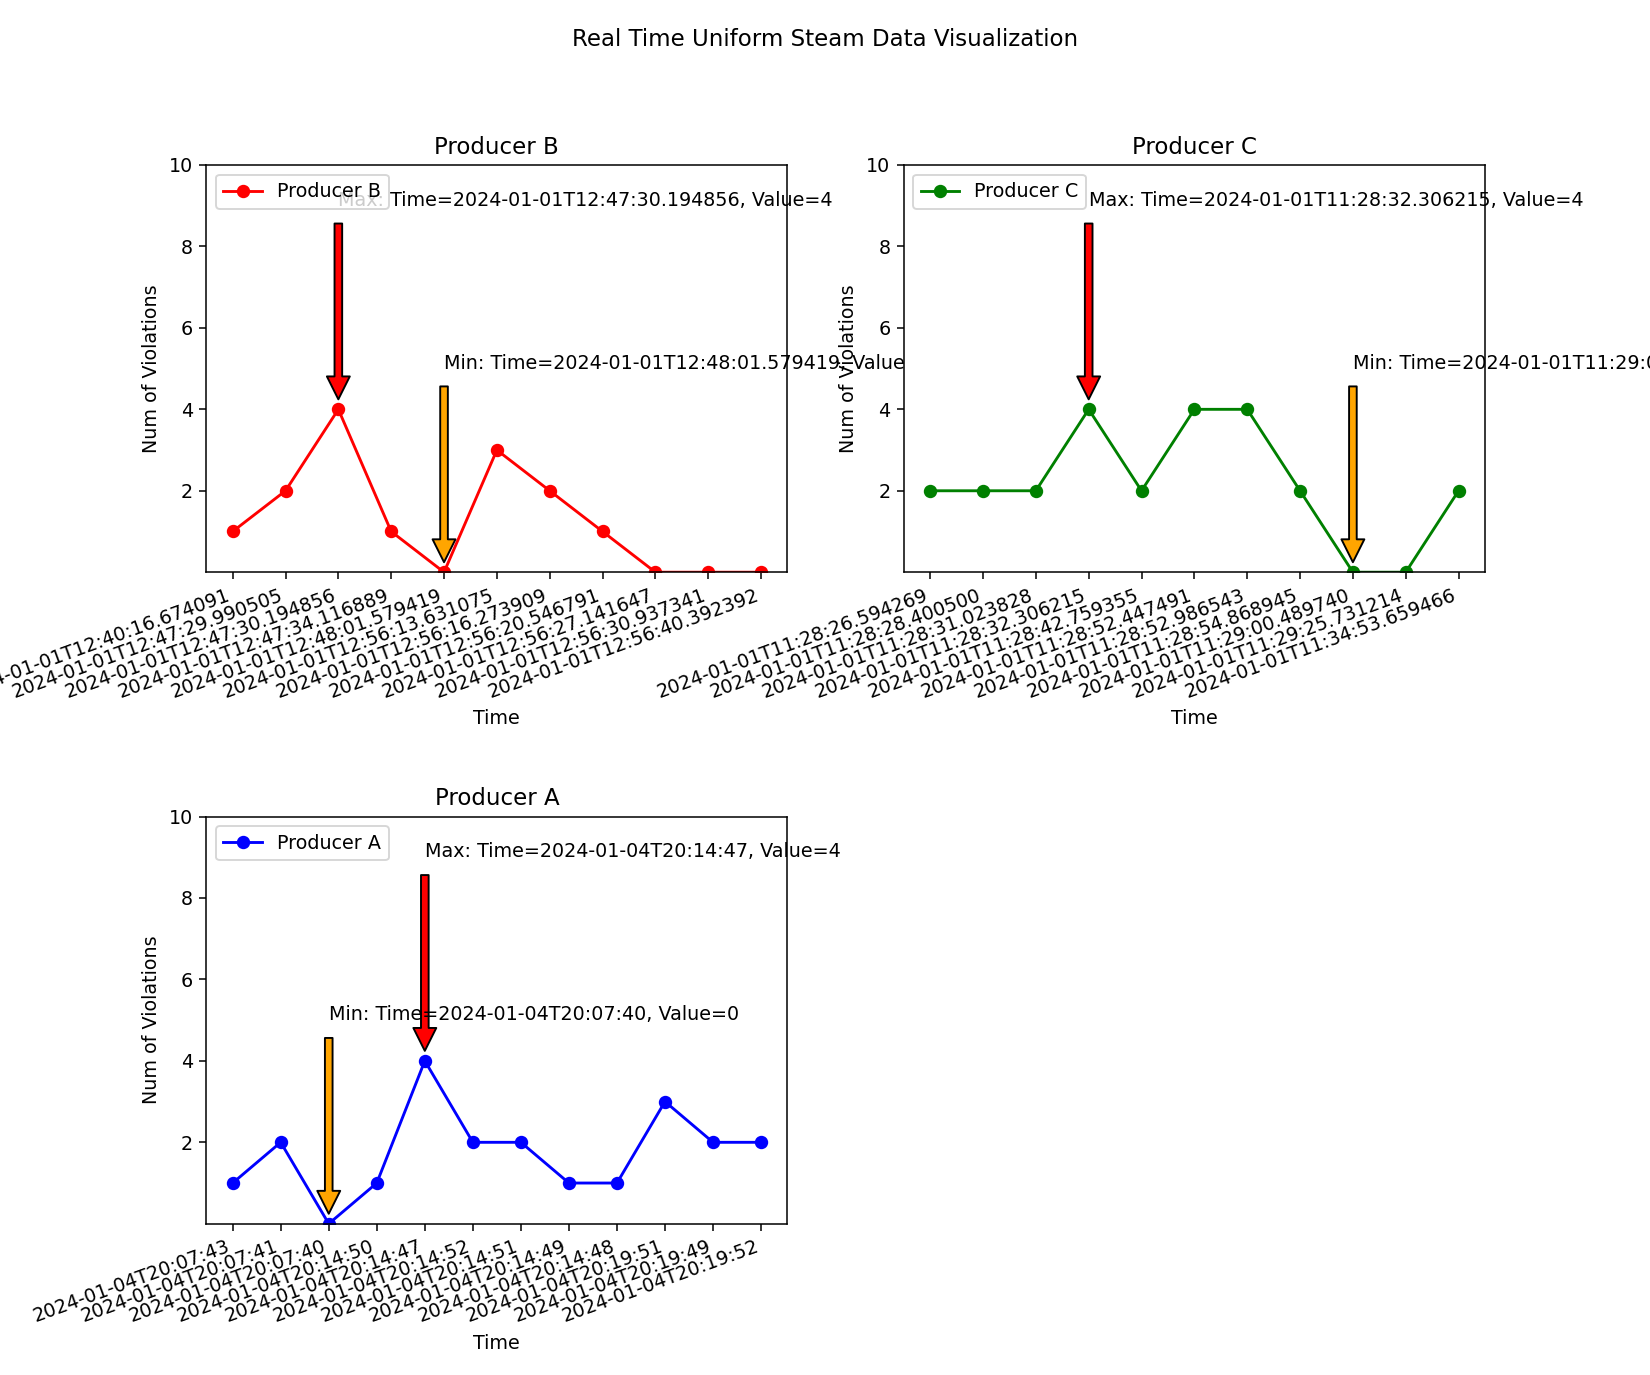

0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
Skipping duplicate timestamp: 2024-01-04T18:34:57
Skipping duplicate timestamp: 2024-01-04T18:34:56
0 1 5
Skipping duplicate timestamp: 2024-01-04T18:34:56
Skipping duplicate timestamp: 2024-01-04T18:34:56
Skipping duplicate timestamp: 2024-01-04T18:34:55
0 1 6
Skipping duplicate timestamp: 2024-01-04T18:34:52
Skipping duplicate timestamp: 2024-01-04T18:34:56
Skipping duplicate timestamp: 2024-01-04T18:34:56
Skipping duplicate timestamp: 2024-01-04T18:34:52
Skipping duplicate timestamp: 2024-01-04T18:34:52
Skipping duplicate timestamp: 2024-01-04T18:34:55
Skipping duplicate timestamp: 2024-01-04T18:34:56
Skipping duplicate timestamp: 2024-01-04T18:34:53
Skipping duplicate timestamp: 2024-01-04T18:34:55
1 1 6
1 2 6
1 2 7
1 2 8
1 2 9
1 2 10
Skipping duplicate timestamp: 2024-01-04T18:43:10
Skipping duplicate timestamp: 2024-01-04T18:43:08
1 2 11
Skipping duplicate timestamp: 2024-01-04T18:43:08
Skipping duplicate timestamp: 2024-01-04T18:43:10
Skipping dupli

11 11 12
Skipping duplicate timestamp: 2024-01-04T19:52:10
11 11 12
Skipping duplicate timestamp: 2024-01-04T19:52:15
Skipping duplicate timestamp: 2024-01-04T19:52:12
Skipping duplicate timestamp: 2024-01-04T19:52:12
12 11 11
12 11 11
11 12 11
11 12 11
11 12 11
11 11 12
11 11 12
11 11 12
11 11 12
11 11 12
Skipping duplicate timestamp: 2024-01-04T20:01:25
Skipping duplicate timestamp: 2024-01-04T20:01:28
Skipping duplicate timestamp: 2024-01-04T20:01:30
Skipping duplicate timestamp: 2024-01-04T20:01:29
Skipping duplicate timestamp: 2024-01-04T20:01:25
11 11 12
Skipping duplicate timestamp: 2024-01-04T20:01:27
Skipping duplicate timestamp: 2024-01-04T20:01:28
Skipping duplicate timestamp: 2024-01-04T20:01:30
Skipping duplicate timestamp: 2024-01-04T20:01:29
Skipping duplicate timestamp: 2024-01-04T20:01:25
Skipping duplicate timestamp: 2024-01-04T20:01:30
Skipping duplicate timestamp: 2024-01-04T20:01:25
Skipping duplicate timestamp: 2024-01-04T20:01:27
Skipping duplicate timestamp: 202

KeyboardInterrupt: 

In [8]:
"""
    Entry point: connects to Kafka and starts the real-time plot.
"""
consumer = connect_kafka_consumer()
fig, ax1, ax2, ax3 = init_vPlots()
consume_vMessages(consumer, fig, ax1, ax2, ax3)

# Speed vs Arrival Time
Plot the Speed recorded every second against arrival time and label interesting points such as maximum and minimum values.

In this section, 3 plots are created for each Producers, where Producer B is plotted with red, C with Green, and A with Blue. The order to plot the producer is not alphabetical order for a reason. This is because Producer A had the most data provided as the streaming data, which made it significant for the test environment to visualize the plots. Furthermore, by plotting the graph as a third entry, it would be place on the next row, which was easier for me to analyse. Additionally, Producer A required from preprocessing before plotting, due to its nature of having no decimal places or no instances of milliseconds recorded within the csv, unlike the other 2.

# Annotation
The plot has been annotated using multiple techniques. 

### Min-Max Extreme:

The Extreme Maximum and Minimum points has been annotated by placing an arrow with Time and Value (Speed) labeled. The red color represents the Maximum point, whereas the yellow represents the minimum point. This annotation is shared among all graphs.

### Connected Plots:

The line graph has a characteristic of plotting the entry of the speed and time as a circle dot. The lines are then connected between those dots to create the line graph.

### Shaded Area:

Yellow shaded area in the background represents the range of Speed Limit. Any entries that goes beyond the shaded area is considered as breaking the speed limit. 

### Average Line:

The average line is represented by creating it in a horizontal dotted form. The average speed samples the 10 instances that are currently plotted within the graph so it changes with respect to the refreshed data. 

# Analysis

The most significant part about this visualization is that the average speed kept close range with the speed limit. Most of the time, the average line went under or beyond the speed limit in a repeating matter. This shows that many drivers tend keep their speed at a close range to the speed limit. 

*The print statements within the codes are left there for a purpose to be used for explanation of the code during the interview.

<IPython.core.display.Javascript object>


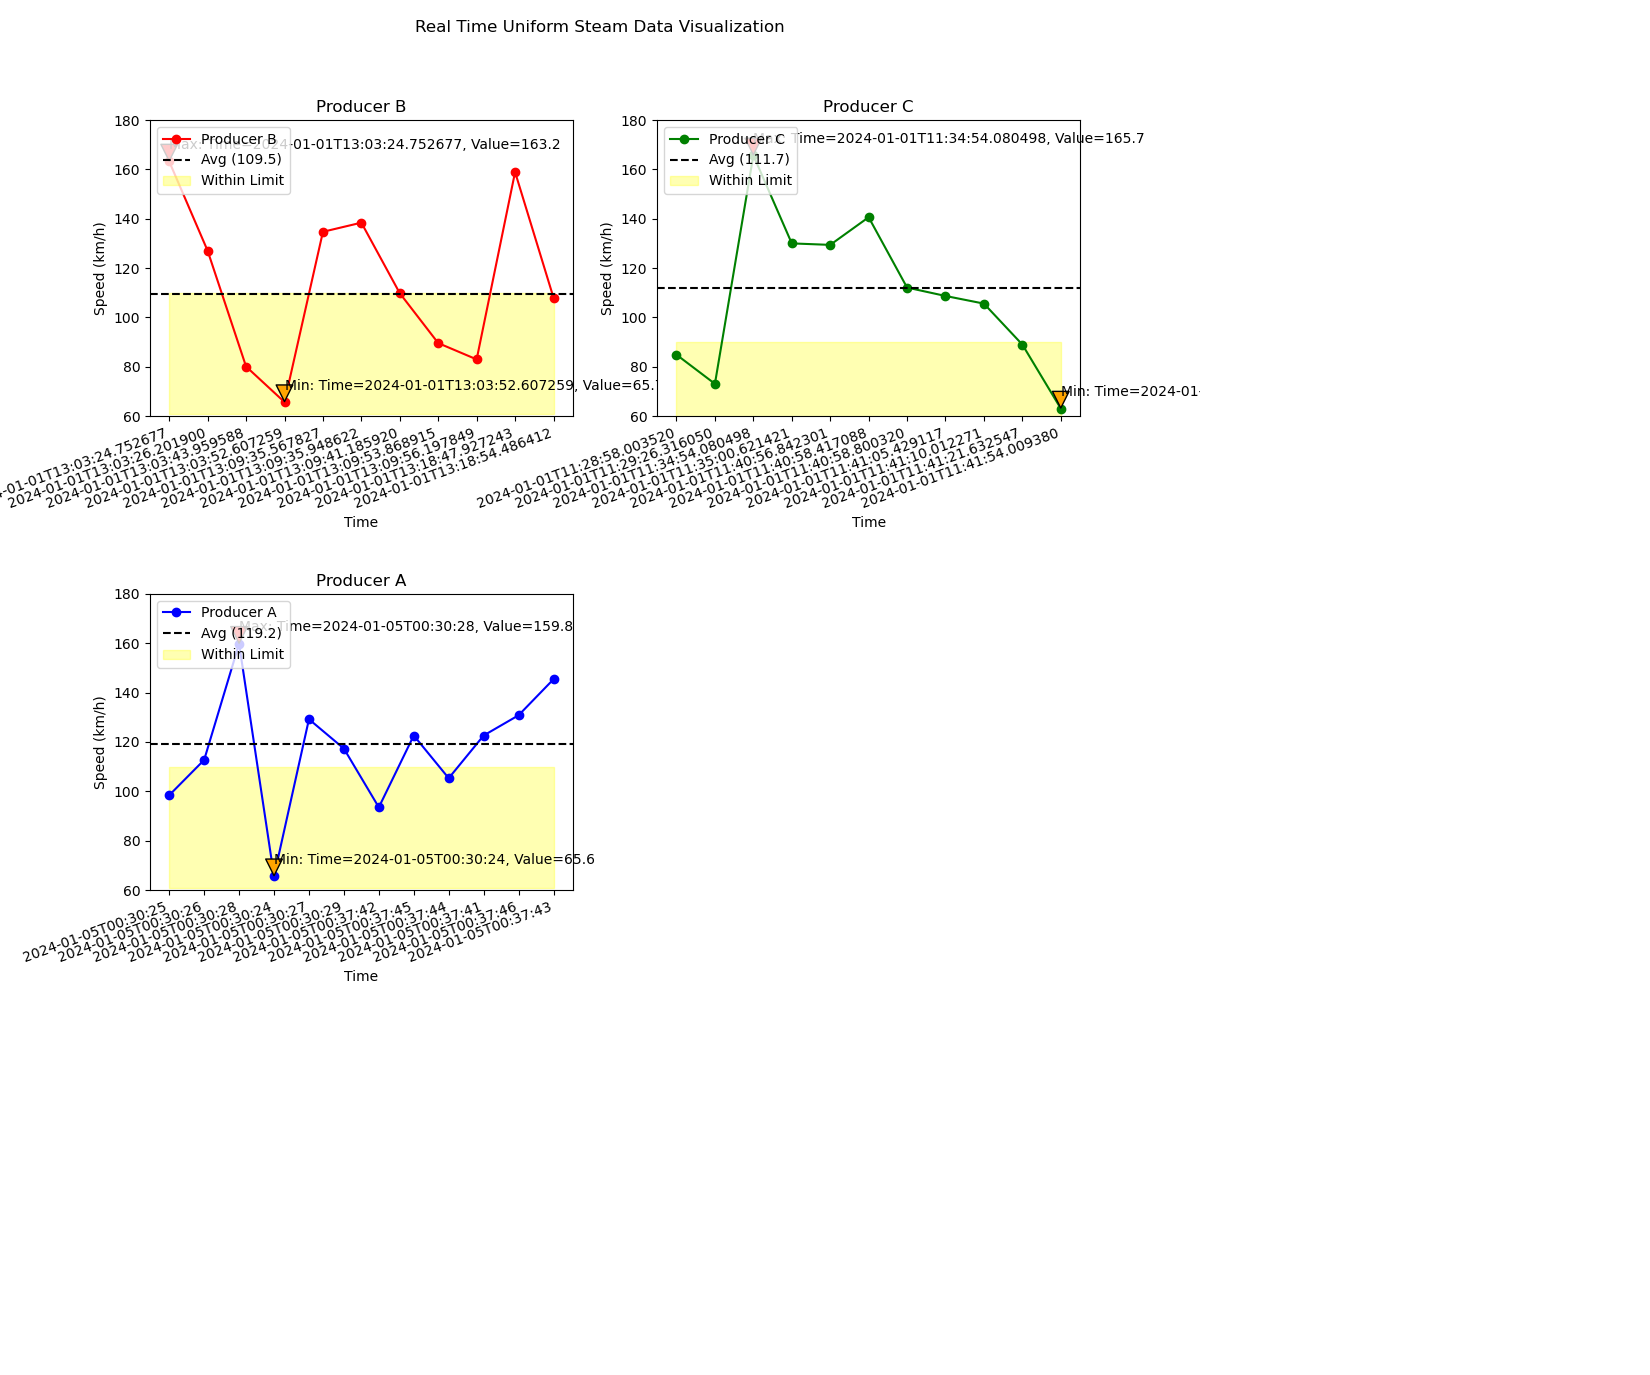

{'event_id': '3a40e43a-19e5-4399-80ff-c8dc60347127', 'batch_id': 433, 'car_plate': 'AXG 7', 'camera_id': 1, 'timestamp': '2024-01-04T22:42:28', 'speed_reading': 156.6, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:03.689958', 'event_date': '2024-01-04'}
{'event_id': '08da744a-5b3e-4c63-9ad2-743f871891ed', 'batch_id': 433, 'car_plate': 'VYG 47', 'camera_id': 1, 'timestamp': '2024-01-04T22:42:28', 'speed_reading': 141.0, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:03.689958', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T22:42:28
{'event_id': 'b6da6586-2e31-4798-bbd3-b3b791ed01e6', 'batch_id': 433, 'car_plate': 'PYK 34', 'camera_id': 1, 'timestamp': '2024-01-04T22:42:29', 'speed_reading': 72.4, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:03.689958', 'event_date': '2024-01-04'}
{'event_id': '267ed700-ad80-448a-b329-2e2d5115aa6e', 'batch_id': 433, 'car_plate': 'QYK 3', 'camera_id': 1

{'event_id': '699c94f3-aa71-4d4d-b5b4-3f9f19107239', 'batch_id': 434, 'car_plate': 'SU 17', 'camera_id': 1, 'timestamp': '2024-01-04T22:50:07', 'speed_reading': 60.2, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:08.710421', 'event_date': '2024-01-04'}
{'event_id': 'fe8c72a0-f086-4ab7-ac0a-b9c5403f039f', 'batch_id': 434, 'car_plate': 'XY 730', 'camera_id': 1, 'timestamp': '2024-01-04T22:50:10', 'speed_reading': 68.1, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:08.710421', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T22:50:10
{'event_id': 'db320cf3-72d8-4ad5-b6e7-cb4f178efa66', 'batch_id': 434, 'car_plate': 'FBL 8', 'camera_id': 1, 'timestamp': '2024-01-04T22:50:10', 'speed_reading': 86.2, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:08.710421', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T22:50:10
{'event_id': 'c9ad075f-5be3-44be-ba02-a054a2ad570f', 'batch

{'event_id': 'd23fc7a5-8a9f-4c14-8f7f-0ad86e960722', 'batch_id': 435, 'car_plate': 'MPG 6697', 'camera_id': 1, 'timestamp': '2024-01-04T22:59:04', 'speed_reading': 90.3, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:13.728525', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T22:59:04
{'event_id': '9c6f6f46-604f-467a-9594-9beb2b003373', 'batch_id': 435, 'car_plate': 'GN 018', 'camera_id': 1, 'timestamp': '2024-01-04T22:58:59', 'speed_reading': 101.5, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:13.728525', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T22:58:59
{'event_id': '76db5b1c-a6f2-4197-9854-c90783a1aec8', 'batch_id': 435, 'car_plate': 'BJK 8', 'camera_id': 1, 'timestamp': '2024-01-04T22:59:00', 'speed_reading': 81.4, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:13.728525', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T22:59:00
{'eve

{'event_id': '00581bf7-3237-45f1-9c2d-3cf8d07d4f76', 'batch_id': 434, 'car_plate': 'RDR 21', 'camera_id': 2, 'timestamp': '2024-01-01T13:09:35.201348', 'speed_reading': 141.1, 'producer_info': 'Producer-B', 'processing_timestamp': '2025-05-29T10:44:20.625091', 'event_date': '2024-01-01'}
{'event_id': '3c4ab7dd-4e3d-480e-8f42-f1131998d3a8', 'batch_id': 434, 'car_plate': 'JFV 2', 'camera_id': 2, 'timestamp': '2024-01-01T13:09:38.878495', 'speed_reading': 134.1, 'producer_info': 'Producer-B', 'processing_timestamp': '2025-05-29T10:44:20.625091', 'event_date': '2024-01-01'}
{'event_id': '4f63daaa-c21b-4317-8b96-9559bd6379ce', 'batch_id': 434, 'car_plate': 'WQG 7252', 'camera_id': 2, 'timestamp': '2024-01-01T13:09:39.393658', 'speed_reading': 135.5, 'producer_info': 'Producer-B', 'processing_timestamp': '2025-05-29T10:44:20.625091', 'event_date': '2024-01-01'}
{'event_id': '9804c176-9032-4a9b-b590-db42ece5dd2c', 'batch_id': 432, 'car_plate': 'FR 3', 'camera_id': 3, 'timestamp': '2024-01-01T

{'event_id': '25617e20-b041-490b-8baf-a9e48bfa47a1', 'batch_id': 433, 'car_plate': 'OSP 455', 'camera_id': 3, 'timestamp': '2024-01-01T11:51:22.167755', 'speed_reading': 71.3, 'producer_info': 'Producer-C', 'processing_timestamp': '2025-05-29T10:44:26.290329', 'event_date': '2024-01-01'}
{'event_id': 'b3cc0324-9e4f-4f03-8178-8a1557edf56e', 'batch_id': 438, 'car_plate': 'DHM 6558', 'camera_id': 1, 'timestamp': '2024-01-04T23:21:23', 'speed_reading': 136.8, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:28.797630', 'event_date': '2024-01-04'}
{'event_id': 'ed2fa852-6573-4c40-858e-aef87f419a67', 'batch_id': 438, 'car_plate': 'ZLP 3759', 'camera_id': 1, 'timestamp': '2024-01-04T23:21:23', 'speed_reading': 149.7, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:28.797630', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T23:21:23
{'event_id': '3d711357-8169-401d-b054-08aa7489dd08', 'batch_id': 438, 'car_plate': 'SKB 9', '

{'event_id': 'e5abcd55-930c-4d7f-bc6d-759e20fabbbe', 'batch_id': 439, 'car_plate': 'OMW 585', 'camera_id': 1, 'timestamp': '2024-01-04T23:29:38', 'speed_reading': 106.8, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:33.852110', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T23:29:38
{'event_id': '41076226-38ce-4dba-9143-98f1c4416bc8', 'batch_id': 439, 'car_plate': 'MLC 84', 'camera_id': 1, 'timestamp': '2024-01-04T23:29:35', 'speed_reading': 132.1, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:33.852110', 'event_date': '2024-01-04'}
{'event_id': 'a27ab690-7b49-4f45-9319-f7fcf2b8f266', 'batch_id': 439, 'car_plate': 'PHV 5428', 'camera_id': 1, 'timestamp': '2024-01-04T23:29:38', 'speed_reading': 70.8, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:33.852110', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T23:29:38
{'event_id': '7a5d2287-41cf-479f-9922-a359123b7013',

{'event_id': 'ebc47a14-6905-443f-909d-76955f609d7e', 'batch_id': 440, 'car_plate': 'PH 299', 'camera_id': 1, 'timestamp': '2024-01-04T23:39:22', 'speed_reading': 106.1, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:38.900218', 'event_date': '2024-01-04'}
{'event_id': '3354ddb9-7abf-431e-b7de-c336c4cd741e', 'batch_id': 440, 'car_plate': 'ZD 6', 'camera_id': 1, 'timestamp': '2024-01-04T23:39:22', 'speed_reading': 105.9, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:38.900218', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T23:39:22
{'event_id': '827d65e0-ac1a-4f4c-b4ce-ff61977c08d2', 'batch_id': 440, 'car_plate': 'VM 4312', 'camera_id': 1, 'timestamp': '2024-01-04T23:39:22', 'speed_reading': 144.9, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:38.900218', 'event_date': '2024-01-04'}
Skipping duplicate timestamp: 2024-01-04T23:39:22
{'event_id': 'c70a566c-76e8-4ecd-b5ad-296e86f301f4', 'b

{'event_id': '81e620dd-c267-4e03-9a2c-b7182d121e02', 'batch_id': 437, 'car_plate': 'WIS 6608', 'camera_id': 3, 'timestamp': '2024-01-01T11:34:54.080498', 'speed_reading': 165.7, 'producer_info': 'Producer-C', 'processing_timestamp': '2025-05-29T10:44:46.350693', 'event_date': '2024-01-01'}
{'event_id': '3bb5fe53-7ed8-451c-873c-b09e80945bd0', 'batch_id': 442, 'car_plate': 'PNO 4', 'camera_id': 1, 'timestamp': '2024-01-04T23:55:11', 'speed_reading': 60.3, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:48.948823', 'event_date': '2024-01-04'}
{'event_id': '1bc5ee0a-6be4-4d77-9fc5-f20fdde0fce3', 'batch_id': 442, 'car_plate': 'XQG 992', 'camera_id': 1, 'timestamp': '2024-01-04T23:55:06', 'speed_reading': 62.8, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:48.948823', 'event_date': '2024-01-04'}
{'event_id': '4042967c-ab13-456d-b0ef-c789c6615517', 'batch_id': 442, 'car_plate': 'CGD 0', 'camera_id': 1, 'timestamp': '2024-01-04T23:55:10', 'sp

{'event_id': '1fbc3b6f-f198-4452-a267-75f71b7b9ac0', 'batch_id': 443, 'car_plate': 'GHG 34', 'camera_id': 1, 'timestamp': '2024-01-05T00:02:06', 'speed_reading': 74.7, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:53.979359', 'event_date': '2024-01-05'}
{'event_id': 'a709cff5-542d-40f5-a184-8a6fa0827127', 'batch_id': 443, 'car_plate': 'IO 3017', 'camera_id': 1, 'timestamp': '2024-01-05T00:02:07', 'speed_reading': 149.3, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:53.979359', 'event_date': '2024-01-05'}
Skipping duplicate timestamp: 2024-01-05T00:02:07
{'event_id': '67503c99-8a72-4375-bbaa-f497a32902da', 'batch_id': 443, 'car_plate': 'ADQ 91', 'camera_id': 1, 'timestamp': '2024-01-05T00:02:07', 'speed_reading': 80.0, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:53.979359', 'event_date': '2024-01-05'}
Skipping duplicate timestamp: 2024-01-05T00:02:07
{'event_id': '5dc88ca7-cdd4-4226-b72f-8055276f758a', 'b

{'event_id': '161cb42a-6829-4ae0-b1d3-6987400c4470', 'batch_id': 444, 'car_plate': 'SVH 33', 'camera_id': 1, 'timestamp': '2024-01-05T00:11:47', 'speed_reading': 149.2, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:59.051468', 'event_date': '2024-01-05'}
{'event_id': 'bae57ea7-63e9-4ba5-b9ad-9d9f681ebf7b', 'batch_id': 444, 'car_plate': 'NI 7904', 'camera_id': 1, 'timestamp': '2024-01-05T00:11:50', 'speed_reading': 148.3, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:59.051468', 'event_date': '2024-01-05'}
Skipping duplicate timestamp: 2024-01-05T00:11:50
{'event_id': 'dc05f46f-a2e4-4b1f-821f-5b92ef3950a3', 'batch_id': 444, 'car_plate': 'TL 7', 'camera_id': 1, 'timestamp': '2024-01-05T00:11:48', 'speed_reading': 116.1, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:44:59.051468', 'event_date': '2024-01-05'}
{'event_id': '8a77b6ac-e3ab-4463-88eb-b45dccbb6817', 'batch_id': 444, 'car_plate': 'VL 08', 'camera_id': 

{'event_id': '897bfb6f-4eb4-4313-a506-c5cce82420dc', 'batch_id': 445, 'car_plate': 'DCI 250', 'camera_id': 1, 'timestamp': '2024-01-05T00:21:12', 'speed_reading': 64.9, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:45:04.107210', 'event_date': '2024-01-05'}
Skipping duplicate timestamp: 2024-01-05T00:21:12
{'event_id': '2ee30998-cd1b-4ebe-a905-fb88844c6c92', 'batch_id': 445, 'car_plate': 'WX 87', 'camera_id': 1, 'timestamp': '2024-01-05T00:21:13', 'speed_reading': 72.5, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:45:04.107210', 'event_date': '2024-01-05'}
Skipping duplicate timestamp: 2024-01-05T00:21:13
{'event_id': '388a2b96-5ab5-45da-b98b-5191d71d82dd', 'batch_id': 445, 'car_plate': 'NGF 37', 'camera_id': 1, 'timestamp': '2024-01-05T00:21:16', 'speed_reading': 132.4, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:45:04.107210', 'event_date': '2024-01-05'}
Skipping duplicate timestamp: 2024-01-05T00:21:16
{'even

{'event_id': '5772b634-c92d-474a-a75f-3df80f5f4414', 'batch_id': 442, 'car_plate': 'UUK 911', 'camera_id': 3, 'timestamp': '2024-01-01T11:41:54.009380', 'speed_reading': 63.1, 'producer_info': 'Producer-C', 'processing_timestamp': '2025-05-29T10:45:11.432578', 'event_date': '2024-01-01'}
{'event_id': '999ab1b8-a460-4656-9312-219f04475cf6', 'batch_id': 447, 'car_plate': 'PLL 68', 'camera_id': 1, 'timestamp': '2024-01-05T00:37:42', 'speed_reading': 93.5, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:45:14.148264', 'event_date': '2024-01-05'}
{'event_id': '5a4c8a44-70d3-438f-810a-eea9027fd134', 'batch_id': 447, 'car_plate': 'CG 65', 'camera_id': 1, 'timestamp': '2024-01-05T00:37:45', 'speed_reading': 122.6, 'producer_info': 'Producer-A', 'processing_timestamp': '2025-05-29T10:45:14.148264', 'event_date': '2024-01-05'}
{'event_id': '0cc478e3-eeb1-433b-8382-72e91dbb5e6d', 'batch_id': 447, 'car_plate': 'HN 656', 'camera_id': 1, 'timestamp': '2024-01-05T00:37:44', 'spe

In [ ]:
if __name__ == '__main__':
    """
    Entry point: connects to Kafka and starts the real-time plot.
    """
    consumer = connect_kafka_consumer()
    fig, ax1, ax2, ax3 = init_plots()
    consume_messages(consumer, fig, ax1, ax2, ax3)

## Map of Camera Locations and Violations
Plot a map using camera locations, annotate number of violations between checkpoints, and identify hotspots.

## Annotations
The graph has been annotated in a way that it demonstrates the number of violations in an area chart that represent the number of violations around the camera by the size of the circle. The marker with the camera icon represents the location of the cameras. 

By hovering over the points made within the map, you can view the details such as the type of camera and number of violations.

In [ ]:
import folium


#Construct a Folium map with set Axis
fomap = folium.Map(location=[2.16, 102.65],zoom_start=15)

# MongoDB aggregation pipelines
segment_pipeline = [
    {"$unwind": "$violations"},
    {"$group": {
        "_id": {
            "start": "$violations.camera_id_start",
            "end":   "$violations.camera_id_end"
        },
        "count": {"$sum": 1}
    }},
    {"$sort": {
        "_id.start": 1,
        "_id.end":   1
    }}
]
camera_pipeline = [
    {"$unwind": "$violations"},
    {"$group": {
        "_id": "$violations.camera_id_start",
        "count": {"$sum": 1}
    }}
]

# Aggregate violation counts for each camera-to-camera segment.
segment_counts = list(db.violations.aggregate(segment_pipeline))

#Aggregate total violation count per camera.
camera_counts = list(db.violations.aggregate(camera_pipeline))
camera_map    = { cc["_id"]: cc["count"] for cc in camera_counts }

#Fetch camera geographic positions from the cameras collection.
cam_positions = {
    cam["camera_id"]: (
        float(cam["latitude"]), 
        float(cam["longitude"])
    )
    for cam in db.cameras.find({}, {"camera_id":1, "latitude":1, "longitude":1})
}

#Construct a Folium map with markers for camera locations and segment midpoints.
for seg in segment_counts:
    start = seg["_id"]["start"]
    end   = seg["_id"]["end"]
    cnt   = seg["count"]
    if start not in cam_positions or end not in cam_positions:
        continue
    lat1, lon1 = cam_positions[start]
    lat2, lon2 = cam_positions[end]
    mid_lat    = (lat1 + lat2) / 2
    mid_lon    = (lon1 + lon2) / 2

    folium.Marker(
        location=[mid_lat, mid_lon],
        radius=4 + cnt * 0.003,
        color="red",
        fill=True,
        fill_opacity=0.6,
        popup=f"Segment {start}→{end}<br>Violations: {cnt}"
    ).add_to(fomap)

violation_counts = list(db.violations.aggregate(camera_pipeline))
viol_map = {vc["_id"]: vc["count"] for vc in violation_counts}

# Used to map the segments between the cameras to annotate the violations inbetween.
adj_pairs = {(1,2), (2,3)}


for cam in db.cameras.find():
    cam_id = cam["camera_id"]
    lat, lon = float(cam["latitude"]), float(cam["longitude"])
    
    # Create a Marker in blue with a video-camera icon.
    folium.Marker(
        location=[lat, lon],
        popup=(
            f"Camera {cam_id}<br>"
            f"Speed Limit: {cam['speed_limit']} km/h"
        ),
        icon=folium.Icon(color="blue", icon="video-camera", prefix="fa")
    ).add_to(fomap)
    
    
    num = viol_map.get(cam_id, 0)
    
    # Label for Hotspot
    if num >= 10000:
        color = "blue"
    else:
        color  = "red"
        
    # Create a circle marker to illustrate the amount of violation using its area.
    folium.CircleMarker(
        location=[lat, lon],
        radius = 4 + num * 0.002,
        color = color,
        fill=True,
        fill_opacity=0.6,
        popup=(
            f"Camera {cam_id}<br>"
            f"Violations: {num}"
        )
    ).add_to(fomap)

In [8]:
fomap